## Лабораторная 5

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

df = pd.read_csv(".//csv//EconomicData.csv")
print(df.columns)
print(df.head())

Index(['stock index', 'country', 'year', 'index price', 'log_indexprice',
       'inflationrate', 'oil prices', 'exchange_rate', 'gdppercent',
       'percapitaincome', 'unemploymentrate', 'manufacturingoutput',
       'tradebalance', 'USTreasury'],
      dtype='object')
  stock index                   country    year  index price  log_indexprice  \
0      NASDAQ  United States of America  1980.0       168.61            2.23   
1      NASDAQ  United States of America  1981.0       203.15            2.31   
2      NASDAQ  United States of America  1982.0       188.98            2.28   
3      NASDAQ  United States of America  1983.0       285.43            2.46   
4      NASDAQ  United States of America  1984.0       248.89            2.40   

   inflationrate  oil prices  exchange_rate  gdppercent  percapitaincome  \
0           0.14       21.59            1.0        0.09          12575.0   
1           0.10       31.77            1.0        0.12          13976.0   
2           0.06   

Бизнес-цель: сегментировать страны на основе экономических показателей для определения схожих групп стран и последующего анализа каждой группы.

In [48]:
df = df.copy()
df_clean = df.dropna()

if not np.issubdtype(df_clean.dtypes.iloc[1], np.number):
    print("Данные содержат текстовые значения.")
    cleaned_data = df_clean.select_dtypes(include=[np.number])

print(f"Исходный размер датасета: {df.shape[0]}")
print(f"Очищенный размер датасета: {df_clean.shape[0]}")

df = pd.get_dummies(df_clean, columns=['country'], drop_first=True)

Данные содержат текстовые значения.
Исходный размер датасета: 369
Очищенный размер датасета: 219


In [49]:
# Выбор признаков для кластеризации
features = ['index price', 'inflationrate', 'oil prices', 'exchange_rate', 'gdppercent', 
            'percapitaincome', 'unemploymentrate', 'manufacturingoutput', 'tradebalance', 'USTreasury']

Стандартизируем, чтобы устранить влияние масштаба.
А также понизим размерность с помощью РСА для уменьшения количества признаков для визуализации данных.

In [50]:
# Предобработка данных: стандартизация
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

# Понижение размерности с помощью PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

Используем метод главных компонент (PCA) для уменьшения размерности данных до 2D для визуализации.

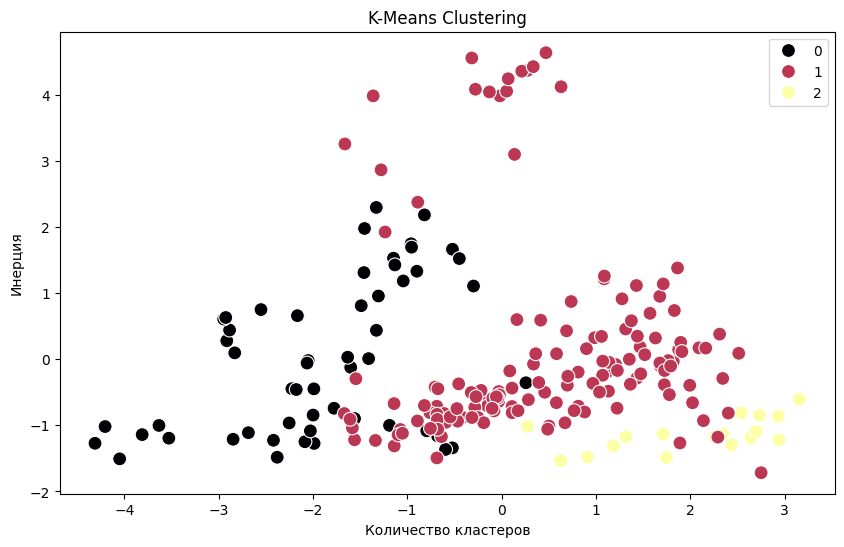

In [51]:
# Неиерархическая
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Визуализация кластеров K-Means
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=kmeans_labels, palette='inferno', s=100)
plt.title('K-Means Clustering')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.show()

#оценка неиерархического
silhouette_avg_kmeans = silhouette_score(scaled_data, kmeans_labels)

Для иерархической кластеризации потребуется предварительно определить количество кластеров, так как она не возвращает метки кластеров.

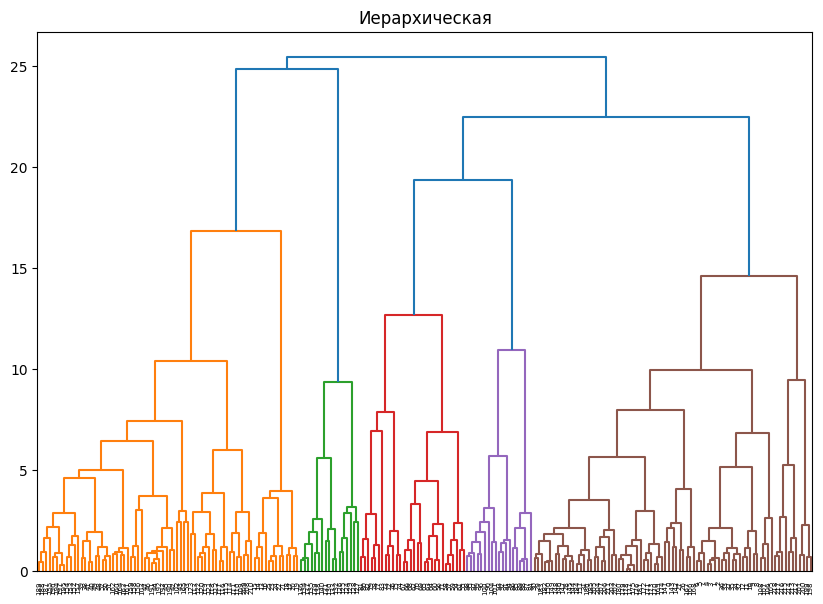

In [52]:
# Иерархическая кластеризация
linked = linkage(scaled_data, 'ward')

# Визуализация
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Иерархическая')
plt.show()

In [53]:
# Определение меток
n_clusters = 3
hierarchical_labels = fcluster(linked, n_clusters, criterion='maxclust')

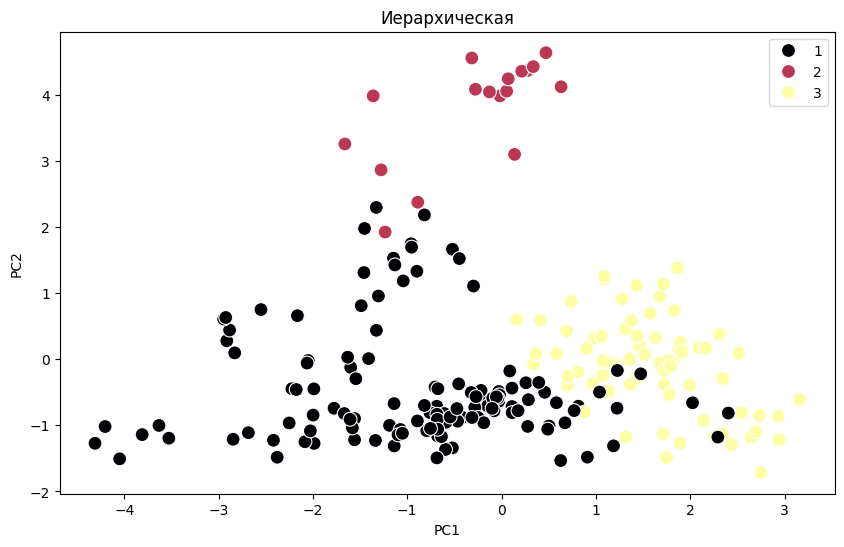

In [54]:
 # Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=hierarchical_labels, palette='inferno', s=100)
plt.title('Иерархическая')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [55]:
# Добавление меток кластеров в исходный датафрейм
df['Cluster'] = kmeans_labels

# Удаление нечисловых столбцов перед вычислением среднего
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
cluster_analysis = df.groupby('Cluster')[numeric_columns].mean()

# Вывод результата
print(cluster_analysis)

                year   index price  log_indexprice  inflationrate  oil prices  \
Cluster                                                                         
0        1998.054545  13563.522364        3.929091       0.054182   34.765091   
1        2005.619048   7237.508776        3.713401       0.020680   48.031361   
2        2009.294118   3554.822941        3.494118       0.022941   59.845294   

         exchange_rate  gdppercent  percapitaincome  unemploymentrate  \
Cluster                                                                 
0            85.857273    0.045818      7502.927273          0.061818   
1             6.610340    0.029320     27037.510204          0.077823   
2             1.000000    0.025294     49157.352941          0.058235   

         manufacturingoutput  tradebalance  USTreasury  
Cluster                                                 
0                 132.100000     -6.739455    0.063636  
1                 473.491633     34.495510    0.042993  


In [59]:
# Оценка
print(f"Оценка для неиерархического: {round(silhouette_avg_kmeans,5)}")

silhouette_avg = silhouette_score(scaled_data, kmeans_labels)
print(f"Оценка для иерархического: {round(silhouette_avg,5)}")

Оценка для неиерархического: 0.20251
Оценка для иерархического: 0.20251


Оценки совпадают, потому что, вероятно, для расхождения в оценке нужно большее число различных данных.